In [1]:
import numpy as np
import pandas as pd
import os
import sys
sys.path.append('/cluster/tufts/hugheslab/prath01/projects/time_series_prediction/src/')
from feature_transformation import parse_feature_cols
import json
import matplotlib.pyplot as plt
%matplotlib inline

## Generate Toy Data

In [2]:
# generate 225 positive data points
n_P = [90, 180, 90]
P = 3
prng = np.random.RandomState(101)

# the first 25 data points come from mean 2-D mvn with mean [1, 2.5] and next 200 come from
# 2-D mvn with mean [1, 1]
mu_PD = np.asarray([
    [0.7, 2.5],
    [0.7, 1.0],
    [0.7, 0.0]])
    
cov_PDD = np.vstack([
    np.diag([0.06, 0.1])[np.newaxis,:],
    np.diag([0.1, 0.1])[np.newaxis,:],
    np.diag([0.06, 0.06])[np.newaxis,:],
    ])

xpos_list = list()
for p in range(P):
    x_ND = prng.multivariate_normal(mu_PD[p], cov_PDD[p], size=n_P[p])
    xpos_list.append(x_ND)
x_pos_ND = np.vstack(xpos_list)
y_pos_N  = np.ones(x_pos_ND.shape[0])

# generate 340 negative data points
n_P = [1200, 90, 60]
P = 3
prng = np.random.RandomState(201)

# the first 300 data points come from mean 2-D mvn with mean [2.2, 1.5] and next 20 come from
# 2-D mvn with mean [0, 3] and next 20 from 2-D mvn with mean [0, 0.5]
mu_PD = np.asarray([
    [2.25, 1.5],
    [0.0, 3.0],
    [0.0, 0.5],
    ])
    
cov_PDD = np.vstack([
    np.diag([.1, .2])[np.newaxis,:],
    np.diag([.05, .05])[np.newaxis,:],
    np.diag([.05, .05])[np.newaxis,:],
    ])

xneg_list = list()
for p in range(P):
    x_ND = prng.multivariate_normal(mu_PD[p], cov_PDD[p], size=n_P[p])
    xneg_list.append(x_ND)
x_neg_ND = np.vstack(xneg_list)
y_neg_N = np.zeros(x_neg_ND.shape[0])

x_ND = np.vstack([x_pos_ND, x_neg_ND])
y_N = np.hstack([y_pos_N, y_neg_N])

# x_ND = (x_ND - np.mean(x_ND, axis=0))/np.std(x_ND, axis=0)

x_pos_ND = x_ND[y_N == 1]
x_neg_ND = x_ND[y_N == 0]

prng = np.random.RandomState(0)
shuffle_ids = prng.permutation(y_N.size)
N_train = int(len(shuffle_ids)*0.4)
N_valid = int(len(shuffle_ids)*0.3)
N_test = int(len(shuffle_ids)*0.3)
train_x_ND = x_ND[shuffle_ids[:N_train]]
train_y_N = y_N[shuffle_ids[:N_train]]

valid_x_ND = x_ND[shuffle_ids[N_train:N_train+N_valid]]
valid_y_N = y_N[shuffle_ids[N_train:N_train+N_valid]]

test_x_ND = x_ND[shuffle_ids[N_train+N_valid:N_train+N_valid+N_test]]
test_y_N = y_N[shuffle_ids[N_train+N_valid:N_train+N_valid+N_test]]

In [3]:
train_y_N.sum()/len(train_y_N)

0.20029239766081872

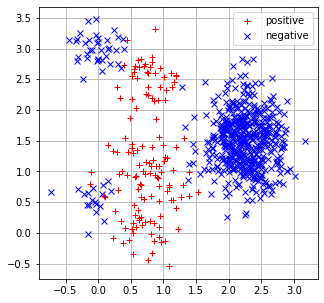

(-3.0, 3.0)

In [4]:
f, axs = plt.subplots(1, 1, figsize=(5,5))

train_x_pos_ND = train_x_ND[train_y_N==1]
train_x_neg_ND = train_x_ND[train_y_N==0]
axs.plot(train_x_pos_ND[:,0], train_x_pos_ND[:,1], 'r+', label='positive')
axs.plot(train_x_neg_ND[:,0], train_x_neg_ND[:,1], 'bx', label='negative')
axs.grid(True)
axs.legend()
plt.show()
axs.set_xlim([-3, 3])

In [5]:
y_N.sum()/len(y_N)

0.21052631578947367

## Get the MIMIC data

In [6]:
mimic_data_dir = '/cluster/tufts/hugheslab/prath01/projects/time_series_prediction/datasets/mimic3_inhospital_mortality/v20201207/split-by=subject_id/collapsed_features_per_sequence/classifier_train_test_split_dir/'
mimic_data_csv = os.path.join(mimic_data_dir, 'x_train.csv')
mimic_df = pd.read_csv(mimic_data_csv)

mimic_dict_file = os.path.join(mimic_data_dir, 'x_dict.json')
mimic_data_dict = json.load(open(mimic_dict_file))
feature_cols = parse_feature_cols(mimic_data_dict['schema'])


## Merge to create semi-synthetic data

In [7]:
mimic_data_np = mimic_df[feature_cols].values
prng = np.random.RandomState(0)
shuffle_ids_mimic = prng.permutation(mimic_data_np.shape[0])

shuffle_ids_mimic_train = shuffle_ids_mimic[:N_train]
shuffle_ids_mimic_valid = shuffle_ids_mimic[N_train:N_train+N_valid]
shuffle_ids_mimic_test = shuffle_ids_mimic[N_train+N_valid:N_train+N_valid+N_test]

train_x_final = np.hstack([train_x_ND, mimic_data_np[shuffle_ids_mimic_train]])
valid_x_final = np.hstack([valid_x_ND, mimic_data_np[shuffle_ids_mimic_valid]])
test_x_final = np.hstack([test_x_ND, mimic_data_np[shuffle_ids_mimic_test]])

## Throw into dataframe and save to csv

In [8]:
final_feature_cols = ['synthetic_0', 'synthetic_1']+feature_cols
outcome_col = ['synthetic_outcome']

In [10]:
n_features = 100

final_x_train_df = pd.DataFrame(train_x_final[:, :n_features], columns=final_feature_cols[:n_features])
final_y_train_df = pd.DataFrame(train_y_N.astype(int), columns=outcome_col)

final_x_valid_df = pd.DataFrame(valid_x_final[:, :n_features], columns=final_feature_cols[:n_features])
final_y_valid_df = pd.DataFrame(valid_y_N.astype(int), columns=outcome_col)

final_x_test_df = pd.DataFrame(test_x_final[:, :n_features], columns=final_feature_cols[:n_features])
final_y_test_df = pd.DataFrame(test_y_N.astype(int), columns=outcome_col)

In [11]:
final_x_train_df

,synthetic_0,synthetic_1,age_hours_since_measured_0%_to_100%,age_hours_since_measured_50%_to_100%,age_hours_since_measured_T-16h_to_T-0h,age_hours_since_measured_T-24h_to_T-0h,age_max_0%_to_100%,age_max_50%_to_100%,age_max_T-16h_to_T-0h,age_max_T-24h_to_T-0h,...,albumin pleural_max_0%_to_100%,albumin pleural_max_50%_to_100%,albumin pleural_max_T-16h_to_T-0h,albumin pleural_max_T-24h_to_T-0h,albumin pleural_median_0%_to_100%,albumin pleural_median_50%_to_100%,albumin pleural_median_T-16h_to_T-0h,albumin pleural_median_T-24h_to_T-0h,albumin pleural_min_0%_to_100%,albumin pleural_min_50%_to_100%
0,2.880471,1.691416,0.0,0.0,0.0,0.0,300.002055,300.002055,300.002055,300.002055,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.514115,2.559671,0.0,0.0,0.0,0.0,85.099495,85.099495,85.099495,85.099495,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.594969,1.354064,0.0,0.0,0.0,0.0,62.542297,62.542297,62.542297,62.542297,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.379812,1.829263,0.0,0.0,0.0,0.0,58.407582,58.407582,58.407582,58.407582,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.080273,-0.545307,0.0,0.0,0.0,0.0,74.996958,74.996958,74.996958,74.996958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,0.865214,2.603674,0.0,0.0,0.0,0.0,300.003810,300.003810,300.003810,300.003810,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
680,-0.453088,3.141700,0.0,0.0,0.0,0.0,76.947201,76.947201,76.947201,76.947201,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
681,1.976163,1.783817,0.0,0.0,0.0,0.0,50.155190,50.155190,50.155190,50.155190,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
682,1.114876,2.595711,0.0,0.0,0.0,0.0,70.399043,70.399043,70.399043,70.399043,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
final_y_train_df

,synthetic_outcome
0,0
1,1
2,1
3,0
4,1
...,...
679,1
680,0
681,0
682,1


In [13]:
semi_synthetic_dir = '/cluster/tufts/hugheslab/prath01/projects/time_series_prediction/datasets/semi_synthetic_precision_recall/'
x_train_csv = os.path.join(semi_synthetic_dir, 'x_train.csv')
y_train_csv = os.path.join(semi_synthetic_dir, 'y_train.csv')

x_valid_csv = os.path.join(semi_synthetic_dir, 'x_valid.csv')
y_valid_csv = os.path.join(semi_synthetic_dir, 'y_valid.csv')

x_test_csv = os.path.join(semi_synthetic_dir, 'x_test.csv')
y_test_csv = os.path.join(semi_synthetic_dir, 'y_test.csv')

final_x_train_df.to_csv(x_train_csv, index=False)
final_y_train_df.to_csv(y_train_csv, index=False)

final_x_valid_df.to_csv(x_valid_csv, index=False)
final_y_valid_df.to_csv(y_valid_csv, index=False)

final_x_test_df.to_csv(x_test_csv, index=False)
final_y_test_df.to_csv(y_test_csv, index=False)

In [14]:
final_x_valid_df.shape

(513, 100)

In [15]:
final_x_test_df.shape

(513, 100)